<a href="https://colab.research.google.com/github/mcbhavana27/ITS/blob/main/tiny_CNN_LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from glob import glob
from keras.models import Sequential,Model,load_model
from keras.metrics import MeanSquaredError as mae
from keras.layers import LSTM,Dense,Dropout,Conv1D,TimeDistributed,Input,Flatten,Concatenate
from keras import regularizers
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import mean_squared_error as mse
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_absolute_percentage_error as mape
from math import sqrt
#from bokeh.plotting import figure,output_file, show
import datetime
from keras.callbacks import ModelCheckpoint
#from openpyxl import Workbook,load_workbook

2022-06-08 22:42:04.031401: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-06-08 22:42:04.031552: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [ ]:
Data_file1= glob('Data/402214'+'/*.csv')
Data_file2= glob('Data/402510'+'/*.csv')
Data_file3= glob('Data/402835'+'/*.csv')
Data_file4= glob('Data/414025'+'/*.csv')

In [ ]:
def data(files,col):
    data=[]
    for file in files:
          data.append(pd.read_csv(file))
    full_data =pd.concat(data,ignore_index=True)
    cols=list(full_data)[col]
    data_set=full_data[cols].astype(str)
    data_set = np.array(data_set)
    return data_set

In [ ]:
Data1 = data(Data_file1,2)
Data2 = data(Data_file2,2)
Data3 = data(Data_file3,2)
Data4 = data(Data_file4,2)

In [ ]:
data1 = Data1.reshape(Data1.shape[0],1)
scaler1 =MinMaxScaler(feature_range=(0, 1))
data1_scaled = scaler1.fit_transform(data1)

In [ ]:
data_set = ([Data1,Data2,Data3,Data4])
max_len =max([len(data) for data in data_set ])

In [ ]:
def fill_data(data):
    x=data
    l=len(x)
    y=x
    while l<max_len:
        y= np.insert(x,-1,x[-1])
        x=y
        l=len(x)
    return y
        

In [ ]:
data1 =fill_data(Data1)
data2 = fill_data(Data2)
data3 = fill_data(Data3)
data4 = fill_data(Data4)
data_set = np.column_stack((data1,data2,data3,data4))

In [ ]:
scaler =MinMaxScaler(feature_range=(0, 1))
data_scaled = scaler.fit_transform(data_set)

In [ ]:
n_step = 21
Data =[]

for i in range(max_len-(n_step+1)):
    Data.append(data_scaled[i:i+n_step+1])

Data =np.array(Data)
#Data = Data.reshape(Data.shape[0],Data.shape[2],Data.shape[1])

In [ ]:
Train = Data[:]
Train_Y=Train[:,-1,0]
Train_X = Train[:,:n_step]
Train_X1 =Train[:,:n_step,0]
Train_wd =Train[:,:n_step]

In [ ]:
x=[]
x1=[]
x_w=[]
x_d=[]
y=[]
for i in range(len(Train)):
    if i >= 2016:
        x.append(Train_X[i])
        x_w.append(Train_X[i-2016])
        x_d.append(Train_X[i-288])
        x1.append(Train_X1[i])
        y.append(Train_Y[i])
x=np.array(x)
x1=np.array(x1)
x_w=np.array(x_w)
x_d=np.array(x_d)
y=np.array(y)      
y=y.reshape(y.shape[0],1)

In [ ]:
x1.shape,x.shape

((24155, 21), (24155, 21, 4))

In [ ]:
train_x=x[:-2016]
test_x=x[-2016:]
train_x1=x1[:-2016]
test_x1=x1[-2016:]
train_x_w=x_w[:-2016]
test_x_w=x_w[-2016:]
train_x_d=x_d[:-2016]
test_x_d=x_d[-2016:]
train_y=y[:-2016]
test_y=y[-2016:]


In [ ]:
train_x1=train_x1.reshape(train_x1.shape[0],train_x1.shape[1],1)
test_x1=test_x1.reshape(test_x1.shape[0],test_x1.shape[1],1)

In [ ]:
from keras.callbacks import EarlyStopping, ModelCheckpoint
checkpoint_path1 = 'Weights/t_cnnlstm/'
cp_callback =ModelCheckpoint(checkpoint_path1,save_weights_only=False,verbose =1)

In [ ]:
input1=Input(shape=(n_step,4),name ='input1')
input2=Input(shape=(n_step,1),name ='input2')
input3=Input(shape=(n_step,4),name ='input3')
input4=Input(shape=(n_step,4),name ='input4')
con1=Conv1D(30,3,padding='same',activation='relu',name='con1')(input1)
con2=Conv1D(30,3,padding='same',activation='relu',name='con2')(con1)
con3=Conv1D(20,2,padding='same',activation='relu',name='con3')(con2)
con_fl = Flatten()(con3)
lstm_out=LSTM(60,activation='relu',return_sequences=False,name='lstm_out')(input2)
lstm_out1=LSTM(30,activation='relu',return_sequences=True,name='lstm_out1')(input3)
lstm_out2=LSTM(30,activation='relu',return_sequences=False,name='lstm_out2')(lstm_out1)
lstm_out3=LSTM(30,activation='relu',return_sequences=True,name='lstm_out3')(input4)
lstm_out4=LSTM(30,activation='relu',return_sequences=False,name='lstm_out4')(lstm_out3)
x=Concatenate()([con_fl,lstm_out,lstm_out2,lstm_out4])
x1=Dense(20,activation='relu',name='x1')(x)
x2=Dense(10,activation='relu',name='x2')(x1)
output1 = Dense(1,activation='relu',kernel_regularizer=regularizers.l1(0.002),name='output1')(x2)
model=Model(inputs=[input1,input2,input3,input4],outputs=output1)
model.compile(optimizer='adam',loss='mse')

2022-06-08 22:45:03.197370: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2022-06-08 22:45:03.197466: W tensorflow/stream_executor/cuda/cuda_driver.cc:269] failed call to cuInit: UNKNOWN ERROR (303)
2022-06-08 22:45:03.197528: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (pravalika): /proc/driver/nvidia/version does not exist
2022-06-08 22:45:03.214436: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [ ]:
history=model.fit([train_x,train_x1,train_x_w,train_x_d],train_y,epochs=100,validation_split=.15,verbose=1,callbacks =[cp_callback])

Epoch 1/100
589/589 [==============================] - ETA: 0s - loss: 0.3798
Epoch 1: saving model to Weights/t_cnnlstm/


2022-06-08 22:45:42.981556: W tensorflow/python/util/util.cc:368] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 39s 46ms/step - loss: 0.3798 - val_loss: 0.4222
Epoch 2/100
589/589 [==============================] - ETA: 0s - loss: 0.0621
Epoch 2: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 50ms/step - loss: 0.0621 - val_loss: 6.2709e-04
Epoch 3/100
589/589 [==============================] - ETA: 0s - loss: 7.0410e-04
Epoch 3: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 30s 51ms/step - loss: 7.0410e-04 - val_loss: 6.5731e-04
Epoch 4/100
589/589 [==============================] - ETA: 0s - loss: 6.4507e-04
Epoch 4: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 59ms/step - loss: 6.4507e-04 - val_loss: 7.0231e-04
Epoch 5/100
588/589 [============================>.] - ETA: 0s - loss: 5.6923e-04
Epoch 5: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 5.6920e-04 - val_loss: 6.6775e-04
Epoch 6/100
589/589 [==============================] - ETA: 0s - loss: 5.4666e-04
Epoch 6: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 59s 100ms/step - loss: 5.4666e-04 - val_loss: 5.0922e-04
Epoch 7/100
589/589 [==============================] - ETA: 0s - loss: 4.9639e-04
Epoch 7: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 62s 106ms/step - loss: 4.9639e-04 - val_loss: 4.8105e-04
Epoch 8/100
589/589 [==============================] - ETA: 0s - loss: 4.8399e-04
Epoch 8: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 61s 104ms/step - loss: 4.8399e-04 - val_loss: 3.0190e-04
Epoch 9/100
589/589 [==============================] - ETA: 0s - loss: 4.6397e-04
Epoch 9: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 62s 105ms/step - loss: 4.6397e-04 - val_loss: 2.8178e-04
Epoch 10/100
589/589 [==============================] - ETA: 0s - loss: 4.3284e-04
Epoch 10: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 62s 105ms/step - loss: 4.3284e-04 - val_loss: 2.4142e-04
Epoch 11/100
589/589 [==============================] - ETA: 0s - loss: 4.1261e-04
Epoch 11: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 63s 107ms/step - loss: 4.1261e-04 - val_loss: 2.2387e-04
Epoch 12/100
589/589 [==============================] - ETA: 0s - loss: 4.0150e-04
Epoch 12: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 65s 110ms/step - loss: 4.0150e-04 - val_loss: 2.4989e-04
Epoch 13/100
588/589 [============================>.] - ETA: 0s - loss: 3.7000e-04
Epoch 13: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 66s 112ms/step - loss: 3.6999e-04 - val_loss: 7.6708e-04
Epoch 14/100
589/589 [==============================] - ETA: 0s - loss: 3.7076e-04
Epoch 14: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 73s 125ms/step - loss: 3.7076e-04 - val_loss: 2.1762e-04
Epoch 15/100
589/589 [==============================] - ETA: 0s - loss: 3.5107e-04
Epoch 15: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 73s 124ms/step - loss: 3.5107e-04 - val_loss: 1.5661e-04
Epoch 16/100
589/589 [==============================] - ETA: 0s - loss: 3.2939e-04
Epoch 16: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 70s 119ms/step - loss: 3.2939e-04 - val_loss: 1.4749e-04
Epoch 17/100
589/589 [==============================] - ETA: 0s - loss: 3.0050e-04
Epoch 17: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 65s 110ms/step - loss: 3.0050e-04 - val_loss: 2.9042e-04
Epoch 18/100
589/589 [==============================] - ETA: 0s - loss: 2.9833e-04
Epoch 18: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 68s 116ms/step - loss: 2.9833e-04 - val_loss: 2.5482e-04
Epoch 19/100
588/589 [============================>.] - ETA: 0s - loss: 2.9457e-04
Epoch 19: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 58s 98ms/step - loss: 2.9455e-04 - val_loss: 1.3061e-04
Epoch 20/100
589/589 [==============================] - ETA: 0s - loss: 2.9059e-04
Epoch 20: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 52s 88ms/step - loss: 2.9059e-04 - val_loss: 1.7142e-04
Epoch 21/100
589/589 [==============================] - ETA: 0s - loss: 2.9374e-04
Epoch 21: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 60s 102ms/step - loss: 2.9374e-04 - val_loss: 1.2609e-04
Epoch 22/100
588/589 [============================>.] - ETA: 0s - loss: 2.7454e-04
Epoch 22: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 43s 73ms/step - loss: 2.7457e-04 - val_loss: 1.1446e-04
Epoch 23/100
589/589 [==============================] - ETA: 0s - loss: 2.7449e-04
Epoch 23: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 32s 54ms/step - loss: 2.7449e-04 - val_loss: 1.3237e-04
Epoch 24/100
589/589 [==============================] - ETA: 0s - loss: 2.8973e-04
Epoch 24: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 33s 57ms/step - loss: 2.8973e-04 - val_loss: 1.2423e-04
Epoch 25/100
588/589 [============================>.] - ETA: 0s - loss: 2.6026e-04
Epoch 25: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 33s 56ms/step - loss: 2.6030e-04 - val_loss: 3.5841e-04
Epoch 26/100
588/589 [============================>.] - ETA: 0s - loss: 2.8401e-04
Epoch 26: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.8399e-04 - val_loss: 1.8533e-04
Epoch 27/100
588/589 [============================>.] - ETA: 0s - loss: 2.5069e-04
Epoch 27: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 40s 67ms/step - loss: 2.5067e-04 - val_loss: 1.0237e-04
Epoch 28/100
589/589 [==============================] - ETA: 0s - loss: 2.5478e-04
Epoch 28: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 42s 72ms/step - loss: 2.5478e-04 - val_loss: 1.7991e-04
Epoch 29/100
588/589 [============================>.] - ETA: 0s - loss: 2.6817e-04
Epoch 29: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 61ms/step - loss: 2.6817e-04 - val_loss: 2.4883e-04
Epoch 30/100
589/589 [==============================] - ETA: 0s - loss: 3.0846e-04
Epoch 30: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 61ms/step - loss: 3.0846e-04 - val_loss: 1.2574e-04
Epoch 31/100
588/589 [============================>.] - ETA: 0s - loss: 2.4331e-04
Epoch 31: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 62ms/step - loss: 2.4330e-04 - val_loss: 1.4040e-04
Epoch 32/100
589/589 [==============================] - ETA: 0s - loss: 2.4975e-04
Epoch 32: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 42s 71ms/step - loss: 2.4975e-04 - val_loss: 9.3654e-05
Epoch 33/100
589/589 [==============================] - ETA: 0s - loss: 2.5401e-04
Epoch 33: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 44s 75ms/step - loss: 2.5401e-04 - val_loss: 9.8829e-05
Epoch 34/100
589/589 [==============================] - ETA: 0s - loss: 2.3593e-04
Epoch 34: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 39s 66ms/step - loss: 2.3593e-04 - val_loss: 6.9988e-04
Epoch 35/100
588/589 [============================>.] - ETA: 0s - loss: 2.5290e-04
Epoch 35: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 2.5288e-04 - val_loss: 3.7305e-04
Epoch 36/100
588/589 [============================>.] - ETA: 0s - loss: 2.5611e-04
Epoch 36: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 47s 79ms/step - loss: 2.5608e-04 - val_loss: 1.0293e-04
Epoch 37/100
589/589 [==============================] - ETA: 0s - loss: 2.4745e-04
Epoch 37: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 44s 75ms/step - loss: 2.4745e-04 - val_loss: 1.0903e-04
Epoch 38/100
589/589 [==============================] - ETA: 0s - loss: 2.3615e-04
Epoch 38: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 44s 74ms/step - loss: 2.3615e-04 - val_loss: 2.7091e-04
Epoch 39/100
588/589 [============================>.] - ETA: 0s - loss: 2.6913e-04
Epoch 39: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 41s 70ms/step - loss: 2.6914e-04 - val_loss: 1.8273e-04
Epoch 40/100
588/589 [============================>.] - ETA: 0s - loss: 2.3417e-04
Epoch 40: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 46s 77ms/step - loss: 2.3415e-04 - val_loss: 2.3671e-04
Epoch 41/100
588/589 [============================>.] - ETA: 0s - loss: 2.5861e-04
Epoch 41: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 46s 78ms/step - loss: 2.5859e-04 - val_loss: 2.5956e-04
Epoch 42/100
588/589 [============================>.] - ETA: 0s - loss: 2.4401e-04
Epoch 42: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 42s 71ms/step - loss: 2.4401e-04 - val_loss: 1.9317e-04
Epoch 43/100
588/589 [============================>.] - ETA: 0s - loss: 2.2956e-04
Epoch 43: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 49s 83ms/step - loss: 2.2955e-04 - val_loss: 1.4388e-04
Epoch 44/100
588/589 [============================>.] - ETA: 0s - loss: 2.3642e-04
Epoch 44: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 40s 68ms/step - loss: 2.3640e-04 - val_loss: 1.0865e-04
Epoch 45/100
588/589 [============================>.] - ETA: 0s - loss: 2.3993e-04
Epoch 45: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 46s 78ms/step - loss: 2.3991e-04 - val_loss: 8.6602e-05
Epoch 46/100
588/589 [============================>.] - ETA: 0s - loss: 2.4051e-04
Epoch 46: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 40s 69ms/step - loss: 2.4049e-04 - val_loss: 9.7116e-05
Epoch 47/100
589/589 [==============================] - ETA: 0s - loss: 2.3705e-04
Epoch 47: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 50s 85ms/step - loss: 2.3705e-04 - val_loss: 1.0819e-04
Epoch 48/100
588/589 [============================>.] - ETA: 0s - loss: 2.3120e-04
Epoch 48: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 48s 81ms/step - loss: 2.3118e-04 - val_loss: 1.0646e-04
Epoch 49/100
588/589 [============================>.] - ETA: 0s - loss: 2.2672e-04
Epoch 49: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 50s 85ms/step - loss: 2.2674e-04 - val_loss: 2.0459e-04
Epoch 50/100
589/589 [==============================] - ETA: 0s - loss: 2.3443e-04
Epoch 50: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 49s 83ms/step - loss: 2.3443e-04 - val_loss: 1.6568e-04
Epoch 51/100
588/589 [============================>.] - ETA: 0s - loss: 2.4855e-04
Epoch 51: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 48s 81ms/step - loss: 2.4853e-04 - val_loss: 1.1542e-04
Epoch 52/100
588/589 [============================>.] - ETA: 0s - loss: 2.5101e-04
Epoch 52: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 56s 96ms/step - loss: 2.5099e-04 - val_loss: 1.5085e-04
Epoch 53/100
588/589 [============================>.] - ETA: 0s - loss: 2.3101e-04
Epoch 53: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 53s 89ms/step - loss: 2.3099e-04 - val_loss: 2.5830e-04
Epoch 54/100
588/589 [============================>.] - ETA: 0s - loss: 2.2692e-04
Epoch 54: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 60ms/step - loss: 2.2691e-04 - val_loss: 1.0454e-04
Epoch 55/100
589/589 [==============================] - ETA: 0s - loss: 2.3511e-04
Epoch 55: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.3511e-04 - val_loss: 5.4503e-04
Epoch 56/100
589/589 [==============================] - ETA: 0s - loss: 2.3365e-04
Epoch 56: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.3365e-04 - val_loss: 8.6179e-05
Epoch 57/100
588/589 [============================>.] - ETA: 0s - loss: 2.3210e-04
Epoch 57: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 59ms/step - loss: 2.3208e-04 - val_loss: 8.0821e-05
Epoch 58/100
589/589 [==============================] - ETA: 0s - loss: 2.2703e-04
Epoch 58: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 38s 64ms/step - loss: 2.2703e-04 - val_loss: 1.8562e-04
Epoch 59/100
588/589 [============================>.] - ETA: 0s - loss: 2.2255e-04
Epoch 59: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 60ms/step - loss: 2.2253e-04 - val_loss: 1.1399e-04
Epoch 60/100
589/589 [==============================] - ETA: 0s - loss: 2.3264e-04
Epoch 60: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.3264e-04 - val_loss: 7.8199e-05
Epoch 61/100
589/589 [==============================] - ETA: 0s - loss: 2.4173e-04
Epoch 61: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 39s 67ms/step - loss: 2.4173e-04 - val_loss: 2.3232e-04
Epoch 62/100
588/589 [============================>.] - ETA: 0s - loss: 2.1518e-04
Epoch 62: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 51s 87ms/step - loss: 2.1516e-04 - val_loss: 1.9719e-04
Epoch 63/100
589/589 [==============================] - ETA: 0s - loss: 2.2359e-04
Epoch 63: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 38s 64ms/step - loss: 2.2359e-04 - val_loss: 9.0586e-05
Epoch 64/100
589/589 [==============================] - ETA: 0s - loss: 2.1835e-04
Epoch 64: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 62ms/step - loss: 2.1835e-04 - val_loss: 9.6636e-05
Epoch 65/100
588/589 [============================>.] - ETA: 0s - loss: 2.1825e-04
Epoch 65: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 61ms/step - loss: 2.1823e-04 - val_loss: 8.2537e-05
Epoch 66/100
589/589 [==============================] - ETA: 0s - loss: 2.1622e-04
Epoch 66: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 62ms/step - loss: 2.1622e-04 - val_loss: 1.5238e-04
Epoch 67/100
588/589 [============================>.] - ETA: 0s - loss: 2.5107e-04
Epoch 67: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 61ms/step - loss: 2.5105e-04 - val_loss: 1.5335e-04
Epoch 68/100
588/589 [============================>.] - ETA: 0s - loss: 2.2418e-04
Epoch 68: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 59ms/step - loss: 2.2417e-04 - val_loss: 2.6252e-04
Epoch 69/100
588/589 [============================>.] - ETA: 0s - loss: 2.3077e-04
Epoch 69: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 59ms/step - loss: 2.3075e-04 - val_loss: 9.3452e-05
Epoch 70/100
588/589 [============================>.] - ETA: 0s - loss: 2.2488e-04
Epoch 70: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 62ms/step - loss: 2.2486e-04 - val_loss: 1.1176e-04
Epoch 71/100
588/589 [============================>.] - ETA: 0s - loss: 2.2349e-04
Epoch 71: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.2347e-04 - val_loss: 1.0375e-04
Epoch 72/100
588/589 [============================>.] - ETA: 0s - loss: 2.1638e-04
Epoch 72: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 2.1636e-04 - val_loss: 8.0548e-05
Epoch 73/100
588/589 [============================>.] - ETA: 0s - loss: 2.2105e-04
Epoch 73: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 2.2104e-04 - val_loss: 1.4166e-04
Epoch 74/100
588/589 [============================>.] - ETA: 0s - loss: 2.1700e-04
Epoch 74: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 34s 58ms/step - loss: 2.1699e-04 - val_loss: 1.1110e-04
Epoch 75/100
588/589 [============================>.] - ETA: 0s - loss: 2.1041e-04
Epoch 75: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 60ms/step - loss: 2.1059e-04 - val_loss: 4.0804e-04
Epoch 76/100
588/589 [============================>.] - ETA: 0s - loss: 2.3132e-04
Epoch 76: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 32s 55ms/step - loss: 2.3131e-04 - val_loss: 1.6851e-04
Epoch 77/100
588/589 [============================>.] - ETA: 0s - loss: 2.0951e-04
Epoch 77: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 28s 48ms/step - loss: 2.0950e-04 - val_loss: 3.0696e-04
Epoch 78/100
589/589 [==============================] - ETA: 0s - loss: 2.1454e-04
Epoch 78: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 49ms/step - loss: 2.1454e-04 - val_loss: 7.8097e-05
Epoch 79/100
589/589 [==============================] - ETA: 0s - loss: 2.2751e-04
Epoch 79: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 49ms/step - loss: 2.2751e-04 - val_loss: 9.5579e-05
Epoch 80/100
589/589 [==============================] - ETA: 0s - loss: 2.1369e-04
Epoch 80: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 49ms/step - loss: 2.1369e-04 - val_loss: 1.1313e-04
Epoch 81/100
588/589 [============================>.] - ETA: 0s - loss: 2.1239e-04
Epoch 81: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 49ms/step - loss: 2.1238e-04 - val_loss: 8.1535e-05
Epoch 82/100
588/589 [============================>.] - ETA: 0s - loss: 2.1599e-04
Epoch 82: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 50ms/step - loss: 2.1597e-04 - val_loss: 1.1478e-04
Epoch 83/100
589/589 [==============================] - ETA: 0s - loss: 2.1745e-04
Epoch 83: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 62ms/step - loss: 2.1745e-04 - val_loss: 8.3853e-05
Epoch 84/100
589/589 [==============================] - ETA: 0s - loss: 2.2981e-04
Epoch 84: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 48ms/step - loss: 2.2981e-04 - val_loss: 2.8320e-04
Epoch 85/100
589/589 [==============================] - ETA: 0s - loss: 2.0476e-04
Epoch 85: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 29s 49ms/step - loss: 2.0476e-04 - val_loss: 1.7041e-04
Epoch 86/100
589/589 [==============================] - ETA: 0s - loss: 2.1239e-04
Epoch 86: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 31s 53ms/step - loss: 2.1239e-04 - val_loss: 1.0519e-04
Epoch 87/100
588/589 [============================>.] - ETA: 0s - loss: 2.0689e-04
Epoch 87: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 33s 56ms/step - loss: 2.0689e-04 - val_loss: 1.2599e-04
Epoch 88/100
588/589 [============================>.] - ETA: 0s - loss: 2.0407e-04
Epoch 88: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 32s 55ms/step - loss: 2.0415e-04 - val_loss: 5.5615e-04
Epoch 89/100
587/589 [============================>.] - ETA: 0s - loss: 2.0702e-04
Epoch 89: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 35s 59ms/step - loss: 2.0699e-04 - val_loss: 9.1733e-05
Epoch 90/100
588/589 [============================>.] - ETA: 0s - loss: 2.1147e-04
Epoch 90: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 31s 52ms/step - loss: 2.1146e-04 - val_loss: 9.5707e-05
Epoch 91/100
588/589 [============================>.] - ETA: 0s - loss: 1.9897e-04
Epoch 91: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 44s 74ms/step - loss: 1.9896e-04 - val_loss: 9.5473e-05
Epoch 92/100
589/589 [==============================] - ETA: 0s - loss: 1.9647e-04
Epoch 92: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 40s 67ms/step - loss: 1.9647e-04 - val_loss: 1.6601e-04
Epoch 93/100
589/589 [==============================] - ETA: 0s - loss: 2.1047e-04
Epoch 93: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 44s 76ms/step - loss: 2.1047e-04 - val_loss: 1.2244e-04
Epoch 94/100
588/589 [============================>.] - ETA: 0s - loss: 1.8779e-04
Epoch 94: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 39s 67ms/step - loss: 1.8778e-04 - val_loss: 8.5045e-05
Epoch 95/100
588/589 [============================>.] - ETA: 0s - loss: 1.9853e-04
Epoch 95: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 43s 73ms/step - loss: 1.9852e-04 - val_loss: 1.5603e-04
Epoch 96/100
588/589 [============================>.] - ETA: 0s - loss: 2.1126e-04
Epoch 96: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 38s 65ms/step - loss: 2.1125e-04 - val_loss: 9.2001e-05
Epoch 97/100
589/589 [==============================] - ETA: 0s - loss: 1.9862e-04
Epoch 97: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 36s 61ms/step - loss: 1.9862e-04 - val_loss: 7.9641e-05
Epoch 98/100
589/589 [==============================] - ETA: 0s - loss: 1.9955e-04
Epoch 98: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 1.9955e-04 - val_loss: 7.9451e-05
Epoch 99/100
588/589 [============================>.] - ETA: 0s - loss: 1.8381e-04
Epoch 99: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 39s 66ms/step - loss: 1.8383e-04 - val_loss: 9.6390e-05
Epoch 100/100
588/589 [============================>.] - ETA: 0s - loss: 1.9794e-04
Epoch 100: saving model to Weights/t_cnnlstm/
INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


INFO:tensorflow:Assets written to: Weights/t_cnnlstm/assets


589/589 [==============================] - 37s 63ms/step - loss: 1.9793e-04 - val_loss: 8.3983e-05


In [ ]:
model_json = model.to_json()
with open("cnn_lstm_model.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("cnn_lstm_model.h5")
print("Saved model to disk")

Saved model to disk


In [ ]:
new_model=model
new_model.load_weights("cnn_lstm_model.h5")

In [ ]:
new_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input1 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                                  
 con1 (Conv1D)                  (None, 21, 30)       390         ['input1[0][0]']                 
                                                                                                  
 con2 (Conv1D)                  (None, 21, 30)       2730        ['con1[0][0]']                   
                                                                                                  
 input3 (InputLayer)            [(None, 21, 4)]      0           []                               
                                                                                              

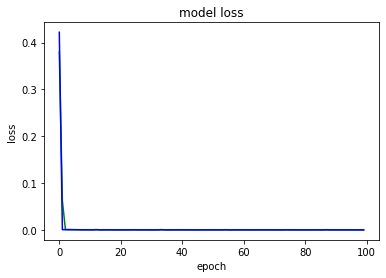

In [ ]:
plt.plot(history.history["loss"],color='green')
plt.plot(history.history["val_loss"],color='blue')
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()


In [ ]:
y_predict_scaled = new_model.predict([test_x,test_x1,test_x_w,test_x_d])

In [ ]:
y_predict=scaler1.inverse_transform(y_predict_scaled)

In [ ]:
test_Y=scaler1.inverse_transform(test_y)

In [ ]:
print(mae(y_predict,test_Y))

0.8392343154502296


In [ ]:
print(sqrt(mse(y_predict,test_Y)))

1.1035074439283903


In [ ]:
print(mape(y_predict,test_Y))

0.015846388422333713


In [ ]:
#tflite

In [ ]:
# tf lite model with quantization
converter = tf.lite.TFLiteConverter.from_keras_model(new_model)
converter.target_spec.supported_ops = [
  tf.lite.OpsSet.TFLITE_BUILTINS, # enable TensorFlow Lite ops.
  tf.lite.OpsSet.SELECT_TF_OPS # enable TensorFlow ops.
]
converter.optimizations = [tf.lite.Optimize.DEFAULT]



# def representative_dataset_generator():
#   for value in X_test:
#     # Each scalar value must be inside of a 2D array that is wrapped in a list
#     print(value)
#     yield [np.array(value, dtype=np.float32, ndmin=2)]
# converter.representative_dataset = representative_dataset_generator
tflite_model = converter.convert()

# Save the model to disk
open("cnn_lstm_model_quantized.tflite", "wb").write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpodexyayb/assets


INFO:tensorflow:Assets written to: /tmp/tmpodexyayb/assets
2022-06-09 00:01:47.701715: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:357] Ignored output_format.
2022-06-09 00:01:47.701749: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:360] Ignored drop_control_dependency.
2022-06-09 00:01:47.702043: I tensorflow/cc/saved_model/reader.cc:43] Reading SavedModel from: /tmp/tmpodexyayb
2022-06-09 00:01:47.732299: I tensorflow/cc/saved_model/reader.cc:78] Reading meta graph with tags { serve }
2022-06-09 00:01:47.732338: I tensorflow/cc/saved_model/reader.cc:119] Reading SavedModel debug info (if present) from: /tmp/tmpodexyayb
2022-06-09 00:01:47.835806: I tensorflow/cc/saved_model/loader.cc:228] Restoring SavedModel bundle.
2022-06-09 00:01:48.215421: I tensorflow/cc/saved_model/loader.cc:212] Running initialization op on SavedModel bundle at path: /tmp/tmpodexyayb
2022-06-09 00:01:48.428425: I tensorflow/cc/saved_model/loader.cc:301] SavedModel

108056

In [ ]:

tf_modelq = tf.lite.Interpreter('cnn_lstm_model_quantized.tflite')
tf_modelq.allocate_tensors()
input_details = tf_modelq.get_input_details()
output_details = tf_modelq.get_output_details()
tf_modelq_predictions = []
input_shape = input_details[0]['shape']
input_shape1 = input_details[1]['shape']
input_shape2 = input_details[2]['shape']
input_shape3 = input_details[3]['shape']
input_data = np.array(test_x, dtype=np.float32)
input_data1 = np.array(test_x1, dtype=np.float32)
input_data2 = np.array(test_x_w, dtype=np.float32)
input_data3 = np.array(test_x_d, dtype=np.float32)
tf_model_output_index = output_details[0]['index']
for i in range(len(test_x1)):
    tf_modelq.set_tensor(input_details[0]['index'], input_data2[i].reshape(1,input_data2.shape[1],input_data2.shape[2]))
    tf_modelq.set_tensor(input_details[1]['index'], input_data[i].reshape(1,input_data.shape[1],input_data.shape[2]))
    tf_modelq.set_tensor(input_details[2]['index'], input_data3[i].reshape(1,input_data3.shape[1],input_data3.shape[2]))
    tf_modelq.set_tensor(input_details[3]['index'], input_data1[i].reshape(1,input_data1.shape[1],input_data1.shape[2]))
    
    tf_modelq.invoke()
    x1=tf_modelq.get_tensor(tf_model_output_index)
    tf_modelq_predictions.append(x1[0])

INFO: Created TensorFlow Lite delegate for select TF ops.
INFO: TfLiteFlexDelegate delegate: 14 nodes delegated out of 64 nodes with 6 partitions.

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [ ]:
tf_pred=scaler1.inverse_transform(tf_modelq_predictions)

NameError: ignored

In [ ]:
print(mae(tf_pred,test_Y))

0.849038697590697


In [ ]:
print(sqrt(mse(tf_pred,test_Y)))

1.1212703204366161


In [ ]:
print(mape(tf_pred,test_Y))

0.015937884220985604


In [ ]:
import os


basic_model_size = os.path.getsize("cnn_lstm_model.h5")
print("Basic model is %d bytes" % basic_model_size)

tflite_model_size = os.path.getsize("cnn_lstm_model.tflite")
print("lite model is %d bytes" % tflite_model_size)

quantized_model_size = os.path.getsize("cnn_lstm_model_quantized.tflite")
print("quantized model is %d bytes" % quantized_model_size)
# print("Difference is %d bytes" % difference)

Basic model is 265072 bytes
lite model is 259616 bytes
quantized model is 108056 bytes


In [ ]:
print(input_data.shape)
print(input_data1.shape)
print(input_data2.shape)
print(input_data3.shape)

(2016, 21, 4)
(2016, 21, 1)
(2016, 21, 4)
(2016, 21, 4)


In [ ]:
print(input_shape)
print(input_shape1)
print(input_shape2)
print(input_shape3)

[ 1 21  4]
[ 1 21  4]
[ 1 21  4]
[ 1 21  1]
